In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
df1=pd.read_csv("tmdb_5000_credits.csv")
df2=pd.read_csv("tmdb_5000_movies.csv")

In [3]:
df1.columns=['id','title','cast','crew']
df2=df2.merge(df1,on='id')
df2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# **Demographic Filtering** -


using IMDB's weighted rating (wr)

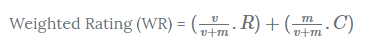

where,

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; 
And C is the mean vote across the whole report
We already have v(vote_count) and R (vote_average) and C can be calculated as

In [4]:
C=df2['vote_average'].mean()
C

6.092171559442011

In [5]:
m=df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [6]:
q_movies = df2.copy().loc[df2['vote_count']>=m]
q_movies.shape

(481, 23)

In [7]:
def weighted_rating(x,m=m,C=C):
    v=x['vote_count']
    R =x['vote_average']
    return (v*R)/(v+m)+(m*C)/(v+m)

In [8]:
q_movies['score']=q_movies.apply(weighted_rating,axis=1)

In [9]:
q_movies=q_movies.sort_values('score',ascending=False)
q_movies[['title_x', 'vote_count', 'vote_average', 'score']].head(5)

,title_x,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239


Text(0.5, 1.0, 'Popular Movies')

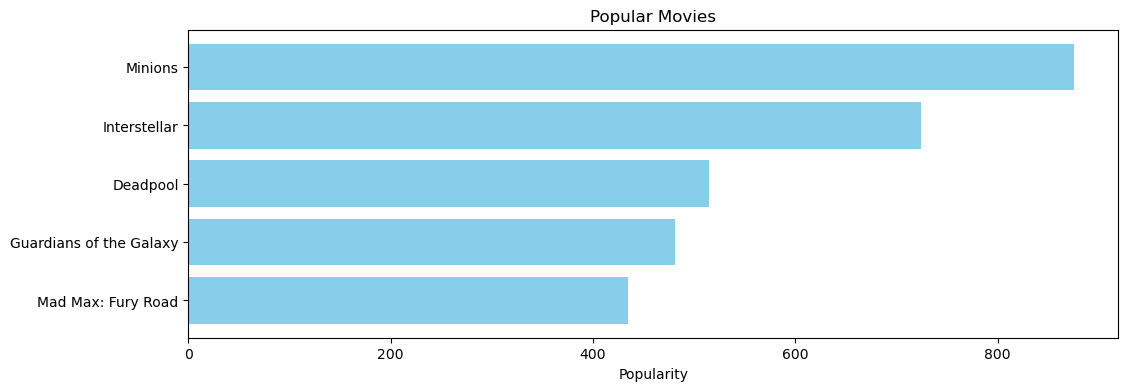

In [10]:
popularity=df2.sort_values('popularity',ascending=False)
plt.figure(figsize=(12,4))

plt.barh(popularity['title_x'].head(5),popularity['popularity'].head(5),
         align='center',color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# CONTENT BASED FILTERING

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset.

In [11]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

For any of you who has done even a bit of text processing before knows we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it?

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')

df2['overview'] = df2['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(df2['overview'])

tfidf_matrix.shape

(4803, 20978)

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
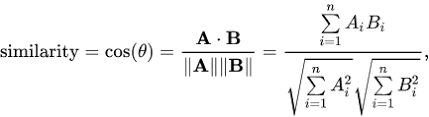

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [13]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [14]:
indices=pd.Series(df2.index,index=df2['title_x']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [15]:
indices['Avatar']


0

In [16]:
def get_recom(title_x,cosine_sim=cosine_sim):
    idx =indices[title_x]
    
    sim_scores=list(enumerate(cosine_sim[idx]))
    
    sim_scores =sorted (sim_scores,key=lambda x:x[1],reverse=True)
    
    sim_scores=sim_scores[1:11]
    
    movie_indices =[i[0] for i in sim_scores]
    
    return df2['title_x'].iloc[movie_indices]

In [17]:
get_recom('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title_x, dtype: object

In [18]:
get_recom('Space Jam')

1889                                       He Got Game
3354                         Michael Jordan to the Max
4153    A Funny Thing Happened on the Way to the Forum
2856                                       Just Wright
3900                                           Air Bud
3731                               High School Musical
2504                                      Juwanna Mann
520                                          Grown Ups
847                                           Semi-Pro
4169                                    Brotherly Love
Name: title_x, dtype: object

In [19]:
get_recom('Pompeii')

141                      Mars Needs Moms
3976                         Close Range
1104                   The Bounty Hunter
627                      The Last Legion
3649                       Lovely, Still
358            Atlantis: The Lost Empire
274                            Gladiator
4743                              The FP
617                                Agora
3878    The Man Who Shot Liberty Valance
Name: title_x, dtype: object

## **Credits, Genres and Keywords Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [20]:
from ast import literal_eval

features = ['cast','crew','keywords','genres']
for feature in features:
    df2[feature]=df2[feature].apply(literal_eval)

In [21]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [22]:
def get_list(x):
    if isinstance(x,list):
        names=[i['name'] for i in x]
        if len(names) >3:
            names =names[:3]
        return names
    return []

In [23]:
df2['director']=df2['crew'].apply(get_director)

features = ['cast','keywords','genres']
for feature in features:
    df2[feature]=df2[feature].apply(get_list)


In [24]:
df2[['title_x','cast','director','genres','keywords']].head()

,title_x,cast,director,genres,keywords
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[Action, Adventure, Fantasy]","[culture clash, future, space war]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[Action, Adventure, Crime]","[spy, based on novel, secret agent]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[Action, Crime, Drama]","[dc comics, crime fighter, terrorist]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [25]:
def clean_data(x):
    if isinstance(x,list):
        return[str.lower(i.replace(" ","")) for i in x]
    else:
        if isinstance(x,str):
            return str.lower(x.replace(" ",""))
        else:
            return ''

In [26]:
features =['cast','keywords','director','genres']

for feature in features:
    df2[feature] =df2[feature].apply(clean_data)

In [27]:
df2[['title_x','cast','director','genres','keywords']].head()

,title_x,cast,director,genres,keywords
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[action, adventure, fantasy]","[cultureclash, future, spacewar]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[adventure, fantasy, action]","[ocean, drugabuse, exoticisland]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[action, adventure, crime]","[spy, basedonnovel, secretagent]"
3,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]",christophernolan,"[action, crime, drama]","[dccomics, crimefighter, terrorist]"
4,John Carter,"[taylorkitsch, lynncollins, samanthamorton]",andrewstanton,"[action, adventure, sciencefiction]","[basedonnovel, mars, medallion]"


In [28]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)


In [29]:
df2['soup']

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4803, dtype: object

COUNT VECTORIZER

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [32]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title_x'])

In [33]:
get_recom('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title_x, dtype: object

In [34]:
get_recom('The Dark Knight Rises',cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title_x, dtype: object

TFIDF VECTORIZER

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['soup'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 11520)

In [36]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim3 =linear_kernel(tfidf_matrix,tfidf_matrix)

In [37]:
indices = pd.Series(df2.index, index=df2['title_x'])

In [38]:
get_recom('The Dark Knight Rises',cosine_sim3)

65               The Dark Knight
119                Batman Begins
1196                The Prestige
4638    Amidst the Devil's Wings
2793        The Killer Inside Me
1033                    Insomnia
95                  Interstellar
1775               The Statement
96                     Inception
739            London Has Fallen
Name: title_x, dtype: object

In [39]:
row = df2.loc[df2['title_x'] == "Amidst the Devil's Wings"]


In [40]:
row

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,director,soup
4638,4638,300000,"[drama, action, crime]",NaN,378237,[],en,Amidst the Devil's Wings,"Prequel to ""5th of a Degree.""",0.018087,...,Released,"Prequel to ""5th of a Degree.""",Amidst the Devil's Wings,0.0,0,Amidst the Devil's Wings,[],[],,drama action crime


It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

# COLLABORATIVE FILTERING

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers.
It is basically of two types:-

*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.
This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.
![](https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png)

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is ***scalability***. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, ***sparsity*** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.

### **Single Value Decomposition**
One way to handle the scalability and sparsity issue created by CF is to leverage a **latent factor model** to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). **The lower the RMSE, the better the performance**.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

![](https://cdn-images-1.medium.com/max/800/1*GUw90kG2ltTd2k_iv3Vo0Q.png)

In [41]:
from surprise import Dataset,SVD,Reader
from surprise.model_selection import cross_validate

min_rating=0.5
max_rating =5.0

rating_scale=(min_rating,max_rating)

reader = Reader(rating_scale=rating_scale)
ratings= pd.read_csv('ratings_small.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [42]:
data=Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)

In [43]:
svd=SVD()
cross_validate(svd,data,measures=['RMSE','MAE'],cv=10,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9019  0.8954  0.8853  0.8806  0.8873  0.9015  0.8941  0.8937  0.8981  0.8747  0.8913  0.0086  
MAE (testset)     0.6948  0.6908  0.6827  0.6804  0.6855  0.6932  0.6856  0.6861  0.6896  0.6708  0.6859  0.0066  
Fit time          4.50    4.61    4.77    5.35    4.95    4.43    4.19    4.24    4.65    4.74    4.64    0.33    
Test time         0.16    0.05    0.05    0.06    0.06    0.05    0.06    0.05    0.13    0.06    0.07    0.04    


{'test_rmse': array([0.90188723, 0.89544188, 0.88528397, 0.88064135, 0.88727337,
        0.90148823, 0.89405631, 0.89370133, 0.89805158, 0.87474289]),
 'test_mae': array([0.69475478, 0.69075949, 0.6827384 , 0.68038325, 0.68553188,
        0.69317744, 0.68556828, 0.68610196, 0.6895834 , 0.67080404]),
 'fit_time': (4.504545450210571,
  4.613868713378906,
  4.767156362533569,
  5.350486516952515,
  4.954026699066162,
  4.430789232254028,
  4.186047315597534,
  4.237319707870483,
  4.645449638366699,
  4.7380828857421875),
 'test_time': (0.15953922271728516,
  0.0547482967376709,
  0.054372310638427734,
  0.06093168258666992,
  0.06422305107116699,
  0.04848933219909668,
  0.055947303771972656,
  0.05182695388793945,
  0.13133740425109863,
  0.06355571746826172)}

We get a mean Root Mean Sqaure Error of 0.8921 with standard deviation of 0.0061 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [44]:
trainset=data.build_full_trainset()
svd.fit(trainset)

In [45]:
ratings[ratings['userId']==1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [46]:
svd.predict(1, 23, 0)

Prediction(uid=1, iid=23, r_ui=0, est=2.280661912529842, details={'was_impossible': False})

In [59]:
def movie_list(target_user_id):
    recommended_movies={}
    for movie_id in trainset.all_items():
        prediction=svd.predict(target_user_id,5,r_ui=None,verbose=False)
        ratings[movie_id] = prediction.est
    top10_movie_id= sorted(recommended_movies,key=recommended_movies.get,reverse=True)[:10]
    return top10_movie_id

In [60]:
recommended_movies_id = movie_list(1)
print(recommended_movies)

[1203, 3462, 7502, 3730, 1223, 318, 1247, 926, 745, 1945]


Here these are top 10 rated movies for the User id 1. Based on collaborative filtering

In [68]:
# Define the movie_list function using user-based collaborative filtering
def movie_list(target_user_id, num_recommendations=10):
    # Create the user-item rating matrix (users x items)
    num_users = trainset.n_users
    num_items = trainset.n_items

    # Initialize an empty user-item matrix filled with zeros
    user_item_matrix = np.zeros((num_users, num_items))

    # Fill the user-item matrix with the known ratings from the trainset
    for (user_id, item_id, rating) in trainset.all_ratings():
        user_item_matrix[user_id, item_id] = rating

    # Get the target user's ratings for all items
    target_user_ratings = user_item_matrix[target_user_id]

    # Compute cosine similarity between the target user and all other users
    similarities = cosine_similarity(user_item_matrix, target_user_ratings.reshape(1, -1))

    # Sort similar users by similarity score in descending order
    similar_users_indices = np.argsort(similarities[:, 0])[::-1]

    # Dictionary to store the estimated ratings for movieIds
    movie_ratings = {}

    for user_idx in similar_users_indices:
        # Skip the target user itself
        if user_idx == target_user_id:
            continue

        for movie_id in range(num_items):
            # Check if the target user has not rated the movie
            if user_item_matrix[target_user_id, movie_id] == 0:
                # Make a prediction for each user-movie pair in similar_users_indices
                prediction = svd.predict(user_idx, movie_id, r_ui=None, verbose=False)

                # Store the estimated rating for the current movieId in the movie_ratings dictionary
                movie_ratings[movie_id] = movie_ratings.get(movie_id, 0) + prediction.est

    # Sort the movie_ratings dictionary by the estimated ratings in descending order
    # Get the top num_recommendations movieIds with the highest estimated ratings
    top_movie_ids = sorted(movie_ratings, key=movie_ratings.get, reverse=True)[:num_recommendations]

    return top_movie_ids

In [69]:
# Call the movie_list function for target_user_id=1 and get top 10 movie recommendations
recommended_movies = movie_list(target_user_id=1, num_recommendations=10)
print(recommended_movies)

[318, 858, 3462, 1221, 926, 1945, 1228, 1217, 969, 1203]


In [70]:
from surprise import Dataset, SVD, Reader
from surprise.model_selection import cross_validate
import pandas as pd

# Load the user-item rating data from the CSV file using pandas
ratings = pd.read_csv('ratings_small.csv')

# Define the minimum and maximum possible ratings in the dataset
min_rating = 0.5
max_rating = 5.0

# Create a Reader object with the specified rating scale
reader = Reader(rating_scale=(min_rating, max_rating))

# Create a Dataset object from the pandas DataFrame
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Instantiate the SVD algorithm
svd = SVD()

# Perform cross-validation for SVD model
svd_cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Instantiate the KNNBasic algorithm for user-based collaborative filtering
from surprise import KNNBasic
user_based = KNNBasic(sim_options={'user_based': True})

# Perform cross-validation for user-based collaborative filtering
user_based_cv_results = cross_validate(user_based, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print average RMSE and MAE for both approaches
print("SVD Results:")
print("Average RMSE:", sum(svd_cv_results['test_rmse']) / 5)
print("Average MAE:", sum(svd_cv_results['test_mae']) / 5)

print("User-Based Collaborative Filtering Results:")
print("Average RMSE:", sum(user_based_cv_results['test_rmse']) / 5)
print("Average MAE:", sum(user_based_cv_results['test_mae']) / 5)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8973  0.8916  0.9094  0.8894  0.8922  0.8960  0.0072  
MAE (testset)     0.6923  0.6869  0.6964  0.6831  0.6899  0.6897  0.0046  
Fit time          4.02    3.59    3.71    3.63    3.74    3.74    0.15    
Test time         0.14    0.12    0.23    0.10    0.09    0.14    0.05    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9713  0.9742  0.9660  0.9623  0.9743  0.9696  0.0047

So we found out the better collaborative algorith here is Model based collaborative filtering as the rmse given is lower as compared to the User based Collaborative filtering.